In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'celebrities-100k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F122892%2F296485%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240406%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240406T220317Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D86832681b380871018f8db7927a0de2c1bcfd87d7097fff8d962a3b0b53fd7bee89909e305558c0ef6bbb9b37766ff41068f25ba1762eeef26aefb87e8ff1b30f91cd0b091182204c48dcb41b73821c388bb70f32cc3b0d8e475d3425bfe5a95313fb931ef27e03cddd02a789dc5f258effa0d439b4dcb129a432ab92b77dac458614bcecab9a38686b064d3dd986bbde0855b7768e6b9c20e1254c07a3ce7f16d532d7034945c57dc12c729348c822ae0f60094099b7b5ea1eb9ce6a97be66e6cc175ff479e0faaf7a91aa8e6e2c700406316efc98a5699b68c12719e26f1db80bdc5614fdb643424b81a0420c15070bfb96d4945009b80f058db90fe7a8eff'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 867862302 bytes downloaded
Downloaded and uncompressed: celebrities-100k
Data source import complete.


# Celebrity Face Generation with GANs

In [3]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os

DATA_DIR = '../input/celebrities-100k/100k/'
print(len(os.listdir(DATA_DIR+'/100k')))

100000


In [5]:
print(os.listdir(DATA_DIR+'/100k')[:10])

['097804.jpg', '035978.jpg', '006529.jpg', '189442.jpg', '181608.jpg', '020684.jpg', '027402.jpg', '024539.jpg', '051446.jpg', '003179.jpg']


Let's load this dataset using the ImageFolder class from torchvision. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range (-1, 1), which is more convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # mean, std for normalize imagess

In [7]:
train_ds = ImageFolder(root=DATA_DIR,
                       transform=T.Compose([T.Resize(image_size),
                                            T.CenterCrop(image_size), # pick central square crop of it
                                            T.ToTensor(),
                                            T.Normalize(*stats)        # normalize => -1 to 1
                                        ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) # use multiple cores


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.



In [8]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

Note that In Pytorch -> C x Hx W whereas Matplotlib reques H x W x C. So, permute(1, 2, 0) do this.

In [9]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

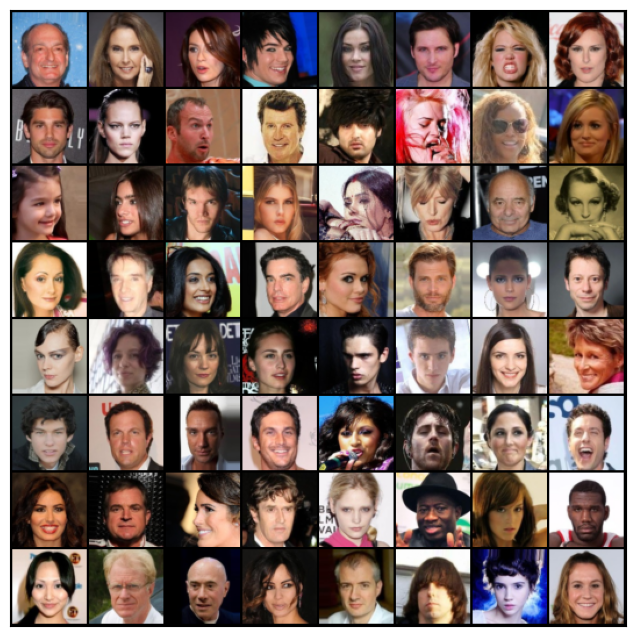

In [10]:
show_batch(train_dl)

## Using a GPU

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    """ 3 things:
    1. Connected to Nvidia GPU
    2. Cuda drivers
    3. Pytorch suitable to GPU version
    then torch.cuda.is_available is True
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

# Build GAN

# Discriminator Network

In [14]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [15]:
discriminator = to_device(discriminator, device)

#### Lets print output shape after each layer of discrminator.

In [16]:
# create a tensor Batch_Size,C,H,W
X = torch.rand(size=(1, 3, 64, 64), dtype=torch.float32, device=device)
for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
LeakyReLU output shape: 	 torch.Size([1, 64, 32, 32])
Conv2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
LeakyReLU output shape: 	 torch.Size([1, 128, 16, 16])
Conv2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
LeakyReLU output shape: 	 torch.Size([1, 256, 8, 8])
Conv2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
LeakyReLU output shape: 	 torch.Size([1, 512, 4, 4])
Conv2d output shape: 	 torch.Size([1, 1, 1, 1])
Flatten output shape: 	 torch.Size([1, 1])
Sigmoid output shape: 	 torch.Size([1, 1])


# Generator Network

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

#### Lets print output shape after each layer of generator.

In [19]:
X = torch.randn(size=(1, 128, 1, 1))
for layer in generator:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

ConvTranspose2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
ReLU output shape: 	 torch.Size([1, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
ConvTranspose2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
ConvTranspose2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([1, 3, 64, 64])
Tanh output shape: 	 torch.Size([1, 3, 64, 64])


#### Lets see fake_images generated by generator before training. Just for curiosity.

torch.Size([128, 3, 64, 64])


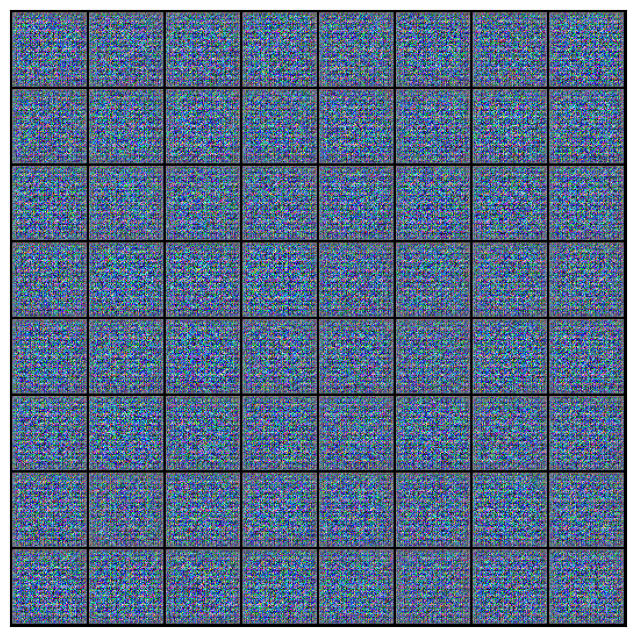

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


#### Remember in PyTorch, we have to move data, model in GPU for computation. So, `to_device` do that work.

In [21]:
generator = to_device(generator, device) # move generator to device

## Training Discriminator

In [22]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through  discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Pass Fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score



Here are the steps involved in training the discriminator.

* We expect the discriminator to output 1 if the image was picked from the real Anime Faces dataset, and 0 if it was generated using the generator network.

* We first pass a batch of real images, and compute the loss, setting the target labels to 1.

* Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

* Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.



It's important to note that we don't change the weights of the generator model while training the discriminator (opt_d only affects the discriminator.parameters())

## Generator Training

* We generate a batch of images using the generator, pass the into the discriminator.

* We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

* We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [23]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1,1, device=device)
  fake_images = generator(latent)

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator
  loss.backward()
  opt_g.step()

  return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [24]:
from torchvision.utils import save_image


In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


Saving generated=images-0000.png


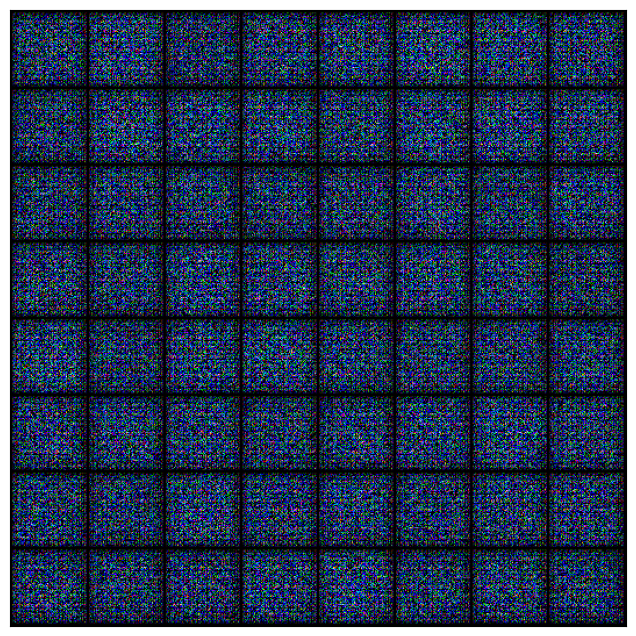

In [28]:
save_samples(0, fixed_latent)

## Training Loop

In [29]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [34]:
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # Create optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      # Train generator
      loss_g = train_generator(opt_g)

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.



In [35]:
# Hyperparameters
lr = 0.0025
epochs = 10

In [36]:
history = fit(epochs, lr)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 1.5790, loss_d: 1.3204, real_score: 0.6282, fake_score: 0.4650
Saving generated=images-0001.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 1.3941, loss_d: 1.4199, real_score: 0.4254, fake_score: 0.3543
Saving generated=images-0002.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 2.0848, loss_d: 0.8210, real_score: 0.6598, fake_score: 0.2129
Saving generated=images-0003.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 1.9105, loss_d: 0.7024, real_score: 0.6850, fake_score: 0.2109
Saving generated=images-0004.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 1.3812, loss_d: 1.4820, real_score: 0.4405, fake_score: 0.1952
Saving generated=images-0005.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 1.9243, loss_d: 0.7497, real_score: 0.7123, fake_score: 0.2664
Saving generated=images-0006.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 3.5247, loss_d: 0.6934, real_score: 0.8984, fake_score: 0.3867
Saving generated=images-0007.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 1.1396, loss_d: 1.1289, real_score: 0.5028, fake_score: 0.1062
Saving generated=images-0008.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 1.8078, loss_d: 0.8760, real_score: 0.6661, fake_score: 0.2774
Saving generated=images-0009.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 2.5007, loss_d: 0.4811, real_score: 0.7771, fake_score: 0.1369
Saving generated=images-0010.png


In [37]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [38]:
losses_g, losses_d, real_scores, fake_scores = history

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.



In [39]:
from IPython.display import Image


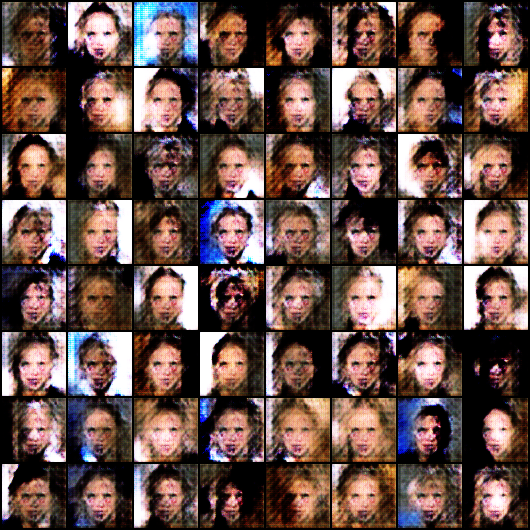

In [40]:
Image('./generated/generated=images-0001.png')


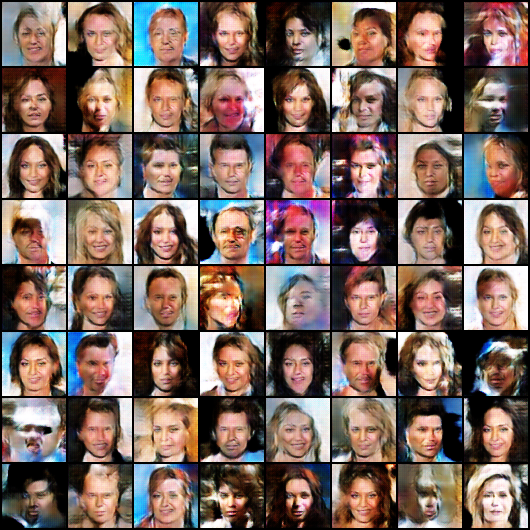

In [41]:
Image('./generated/generated=images-0005.png')


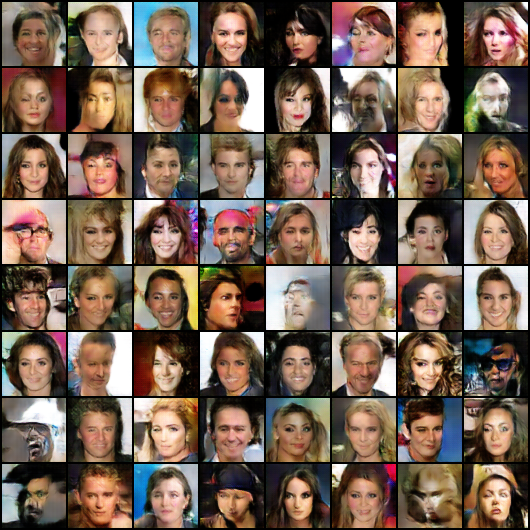

In [42]:
Image('./generated/generated=images-0010.png')


In [43]:
Image('./generated/generated=images-0020.png')


FileNotFoundError: No such file or directory: './generated/generated=images-0020.png'

FileNotFoundError: No such file or directory: './generated/generated=images-0020.png'

<IPython.core.display.Image object>

In [ ]:
Image('./generated/generated=images-0025.png')


In [ ]:
Image('./generated/generated=images-0030.png')

In [ ]:
Image('./generated/generated=images-0035.png')

In [ ]:
Image('./generated/generated=images-0040.png')

In [ ]:
Image('./generated/generated=images-0045.png')

In [ ]:
Image('./generated/generated=images-0050.png')

In [44]:
Image('./generated/generated=images-0055.png')

FileNotFoundError: No such file or directory: './generated/generated=images-0055.png'

FileNotFoundError: No such file or directory: './generated/generated=images-0055.png'

<IPython.core.display.Image object>

In [ ]:
Image('./generated/generated=images-0060.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.



In [45]:
import cv2
import os

vid_fname = 'gans_training.avi'

print("Starting converting images to video.")
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

print(files)

fourcc = cv2.VideoWriter_fourcc(*'MPEG')
out = cv2.VideoWriter(vid_fname,fourcc, 1.0, (640,480))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
print("DONE!")

Starting converting images to video.
['generated/generated=images-0000.png', 'generated/generated=images-0001.png', 'generated/generated=images-0002.png', 'generated/generated=images-0003.png', 'generated/generated=images-0004.png', 'generated/generated=images-0005.png', 'generated/generated=images-0006.png', 'generated/generated=images-0007.png', 'generated/generated=images-0008.png', 'generated/generated=images-0009.png', 'generated/generated=images-0010.png']
DONE!


Here's what it looks like:



We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

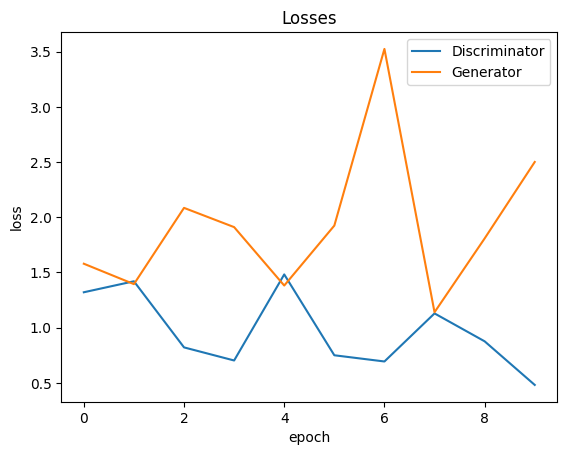

In [46]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

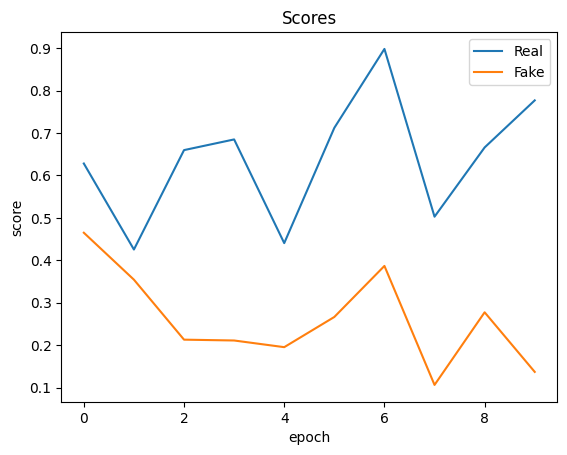

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');